# Read/process all IR images

In [1]:
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
import kray
# OS interaction
import sys, pickle, os
# import subplots function for plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph
import matplotlib.gridspec as gridspec
from moviepy.editor import *

# --------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/'
# Directory for printing figures
dirPrint = dirPre + 'SnowHydrology/proj/TurbulenceFeedbacks/Graphics/IR_SnoqualmieFlights'
# Met data directory
dirData = dirPre + 'SnowHydrology/proj/TurbulenceFeedbacks/data/SNQ/IR_SnoqualmieFlights'
dirDataGrobs = dirPre + 'SnowHydrology/proj/TurbulenceFeedbacks/data/SNQ/'

# --------------------------------------------------------------------------------------------
# Global formatting
sns.set_context('talk')
sns.set_style('whitegrid')
# must insert this statement to render the plots within the notebook
%matplotlib inline

In [2]:
# --------------------------------------------------------------------------------------------
# Functions/classes for reading binary files in python
# From: http://code.activestate.com/recipes/577610-decoding-binary-files/
import struct

class BinaryReaderEOFException(Exception):
    def __init__(self):
        pass
    def __str__(self):
        return 'Not enough bytes in file to satisfy read request'

class BinaryReader:
    # Map well-known type names into struct format characters.
    typeNames = {
        'int8'   :'b',
        'uint8'  :'B',
        'int16'  :'h',
        'uint16' :'H',
        'int32'  :'i',
        'uint32' :'I',
        'int64'  :'q',
        'uint64' :'Q',
        'float'  :'f',
        'double' :'d',
        'char'   :'s'}

    def __init__(self, fileName):
        self.file = open(fileName, 'rb')
        
    def seek(self, seekLocation):
        self.file.seek(seekLocation)

    def read(self, typeName):
        typeFormat = BinaryReader.typeNames[typeName.lower()]
        typeSize = struct.calcsize(typeFormat)
        value = self.file.read(typeSize)
        if typeSize != len(value):
            raise BinaryReaderEOFException
        return struct.unpack(typeFormat, value)[0]

    def __del__(self):
        self.file.close()

## Read IR Function

In [3]:
def readInfraredCamera(fname,
                       findex=[0.],
                       params=([1904, 1904, 16, 640, 480]),
                      infoOnlyFlag=True):
    '''
    fname   - string, filename of the IR camera files. Requires a corresponding GPS/IMU and timefile
    findex  - numpy array of integers, image numbers to read
    params  - numpy array of integers, describes image
    '''
    # params - [bit_header_offset bit_spacer bit_depth width height]
    # findex - specific frames to read in
    
    # --------------------------------------------------------------------------------------------
    # get params for reading in and making data output
    info = {}
    info['hbit'] = params[0]
    info['obit'] = params[1]
    info['bit'] = params[2]
    info['bitdepth'] = info['bit']
    info['width'] = params[3]
    info['height'] = params[4]
    
    # --------------------------------------------------------------------------------------------
    # Image information
    fInfo = os.stat(fname)

    # calculated frame number
    nFrames = round((fInfo.st_size - (info['hbit'] -info['obit'])/8)
                    /((info['width'] * info['height'] * info['bitdepth'] + info['obit']) / 8)) 
    info['nframes'] = nFrames

    # --------------------------------------------------------------------------------------------
    # read time and temp from timesFile
    # Time files have the same file name as the corresponding '*.dat' files
    timeFilename = fname.split('.')[0]
    timeFilename = timeFilename + '.txt'

    # Check to see that the time file exists (nothing here yet)
    # I think the best solution here is to throw an error if no file is found.
    # The pandas 'read_csv' (below) should already give us this desired behavior

    # Read the file with time stamps and camera temperatures for each image
    timeFile = pd.read_csv(timeFilename,
                           header=None,
                           names=['epochTime',
                                  'tempName1', 'camTemp',
                                  'tempName2', 'refTemp'], 
                           index_col='epochTime')
    timeFile.drop('tempName2', axis=1, inplace=True)
    timeFile.drop('tempName1', axis=1, inplace=True)
    
    # Assumes we are reading a csv with this form:
    # 5 columnes: 1 time stamp, 4 giving camera temperatures (label1, temp1, label2, temp2)
    # "1368578461.593, 280F9A5403000002 , 8.63 , 287FE81C040000F2 , 9.19"
    # OR
    # 1 column: time stamp
    # "1368578461.593"
    #
    # Something about the temp probes was changed after April 2013 resulting in two different code
    # blocks to handle each in the original matlab code. Since all of the data I'm using is after
    # that date, I am going to ignore the code for data prior to that date

    # Each time stamp corresponds to an IR image.
    numImages = timeFile.index.size
    # Convert to numpy64 datetime objects (epochTime is in seconds since 1970)
    timeFile.index = [datetime.fromtimestamp(d) for d in timeFile.index.values]
    # exit on infoFlag
    if infoOnlyFlag:
        return(info, timeFile)
        
    # --------------------------------------------------------------------------------------------
    # Acquire IR camera images
    numFrames = fIndex.size
    info['nFrames'] = numFrames

    # There is this 'uvs' argument in the original matlab read script, but it isn't defined. This
    # variable is never used in the 'snowIR_example.m' script, so I'm going to ignore the code block
    # that handles it.
    binDataOut = np.zeros([info['height'], info['width'], info['nFrames']])
    imageSize = info['width'] * info['height']

    for j in np.arange(0, numFrames):
        # Update progress
        if numFrames > 1:
            print("\r", '%d of %d' % (j+1, numFrames), end="")

        # Discover next position in binary file
        seekBitLoc = (info['width'] * info['height'] * (info['bit'] / 8) + info['obit'] / 8) \
                     * (fIndex[j]) + info['hbit'] / 8
        seekBitLoc = int(seekBitLoc)

        # Ready binary file
        binaryReader = BinaryReader(fname)
        # Point python to the desired location in the binary file (0 means seek from beginning of file)
        binaryReader.seek(seekBitLoc)
        try:
            numBinaryItems = imageSize
            data = np.empty(numBinaryItems)
            for binIndex in np.arange(numBinaryItems):
                data[binIndex] = binaryReader.read('uint16')
            binDataOut[:, :, j] = data.reshape(info['height'], info['width'])

        except BinaryReaderEOFException:
            # One of our attempts to read a field went beyond the end of the file.
            print("Error: File seems to be corrupted.")
    
    # Convert data to xarray Dataset before returning variables
    cameraDataset = xr.Dataset({'images': (['x', 'y', 'time'],  binDataOut)},
                       coords={'time': cameraTime.index[fIndex]})
    
    # Mean counts to remove from data
    imMean = cameraDataset.mean(dim='time')
    # Camera reference temperature
    refTemp = cameraTime.camTemp.mean()
    # Convert to a brightness temperature following the example in Chris' MATLAB script
    cameraDataset.images.values = (cameraDataset.images - imMean.images) / 250 + refTemp
    
    # Return brightness temperature
    return cameraDataset, cameraTime

## Read GPS/IMU

In [4]:
import utm


def readIMU(fname):
    # Column 1 is time
    # Columns 12 and 13 are lat and lon
    # Columns 2-9 are actually column 2 in the readme and original MATLAB code - they are demarked using a semi-colon

    try:
        # Pandas based reading of the gps file
        temp = pd.read_csv(fname, skiprows=1, header=None, index_col=[0])

        # Drop rows with "#BESTPOSA"
        temp = temp[temp[1] != '#BESTPOSA']
        d = {'lat': temp[12],
             'lon': temp[13],
             'pitch': temp[19],
             'roll': temp[18],
             'azmth': temp[20],
             'elev': temp[14],
             'velocity': temp[17]}
        gpsFile = pd.DataFrame(d)
        gpsFile.index.rename('time', inplace=True)

        # Convert to numpy64 datetime objects (epochTime is in seconds since 1970)
        gpsFile.index = [datetime.fromtimestamp(d) for d in gpsFile.index.values]
        gpsFile.index.rename('time', inplace=True)

        # Convert to UTM coordinates - returned from function (lat, lon, zone, _)
        [gpsFile['easting'], gpsFile['northing'], gpsFile['zone']] = zip(
            *(utm.from_latlon(lat, lon)[0:3] for (lat, lon) in zip(gpsFile.lat, gpsFile.lon)))
    except ValueError:
        # GPS file likely only contains the "#BESTPOSA" without a corresponding "#INSPVAA" row.
        # Return just the GPS locations instead of the IMU+GPS (I think). Return an empty Dataset.
        print("No location data found in: " + fname)
        return xr.Dataset()

    return(xr.Dataset.from_dataframe(gpsFile))

## Undistort

In [5]:
def undistortUV(Ud, Vd, ip):
    '''
    [U V] = undistortUV(Ud,Vd,ip)
    ip - [lx ly uWidth vWidth u0 v0 d1 d2]
    '''
    # separate parameters
    lu = ip[0]
    lv = ip[1]
    Uo = ip[4]
    Vo = ip[5]
    d1 = ip[6]
    d2 = ip[7]
    if len(ip) > 8:
        d3 = ip[8]

    # calculate radius
    r = np.sqrt((lu * Ud - Uo)**2 + (lv * Vd - Vo)**2)

    # calculate scaling factor
    if len(ip) > 8:
        s = 1 + d1 * r**2 + d3 * r + d2
    else:
        s = 1 + d1 * r**2 + d2

    # undistort UV
    U = ((lu * Ud - Uo) * s + Uo) / lu
    V = ((lv * Vd - Vo) * s + Vo) / lv 
    
    return(U, V)

## Walton M vector

In [6]:
def infoPRY2M(angles, camera, ip, 
              oPitch=None, oRoll=None, oYaw=None):
    '''
    infoPRY2M -- convert ptich, roll yaw angles and camera/IP data to M vector
    
    m = info2M( angles, camera, ip ) converts the angle data into
    a Walton M vector based on camera location and IP data.

    Angles is a 4x1 or 1x4 array of angles in the order [pitch
    yaw hfov roll], in radians

    Camera is a 3 element vector of camera location values in the order
    [x y z].

    IP is a 6 element vector in order of [lx ly uWidth vWidth u0 v0].
    Or IP is the usual ip structure format.
    '''
    
    # set parameters
    pitch, yaw, fov, roll  = angles
    cx, cy, cz = camera
    lu = ip[0]
    lv = ip[1]
    width = ip[2]
    u0 = ip[4]
    v0 = ip[5]

    # use camera space
    f = width/ 2 / np.tan(fov / 2)

    # INS rotation matrix
    a = np.array([np.cos(yaw), np.sin(yaw), 0,
                  -np.sin(yaw), np.cos(yaw), 0,
                  0, 0, 1]).reshape(3, 3)
    b = np.array([np.cos(roll), 0, -np.sin(roll),
                  0, 1, 0,
                  np.sin(roll), 0, np.cos(roll)]).reshape(3, 3)
    c = np.array([1, 0, 0,
                  0, np.cos(pitch), np.sin(pitch),
                  0, -np.sin(pitch), np.cos(pitch)]).reshape(3, 3)

    # offset rotation to the cameras
    if oPitch is not None or oRoll is not None or oYaw is not None:
        a2 = np.array([np.cos(oYaw), np.sin(oYaw), 0,
              -np.sin(oYaw), np.cos(oYaw), 0,
              0, 0, 1]).reshape(3, 3)
        b2 = np.array([np.cos(oRoll), 0, -np.sin(oRoll),
                       0, 1, 0,
                       np.sin(oRoll), 0, np.cos(oRoll)]).reshape(3, 3)
        c2 = np.array([1, 0, 0,
                       0, np.cos(oPitch), np.sin(oPitch),
                       0, -np.sin(oPitch), np.cos(oPitch)]).reshape(3, 3)
        Rg = np.dot(np.dot(a2, b2), c2)
        # INS to local (ENU) rotation, with offset to camera rotaion
        R = np.dot(np.dot(np.dot(a, b), c), Rg).T
    else:
        # INS to local (ENU) rotation
        R = np.dot(np.dot(b, c), a)
    L = -(cx * R[2, 0] + cy * R[2, 1] + cz * R[2, 2])

    # m vector
    m = np.zeros(11)
    m[0] = lu * (u0 * R[2, 0] + f * R[0, 0]) / L
    m[1] = lu * (u0 * R[2, 1] + f * R[0, 1]) / L
    m[2] = lu * (u0 * R[2, 2] + f * R[0, 2]) / L

    m[3] = -(m[0] * cx + m[1] * cy + m[2] * cz)

    m[4] = R[2, 0] / L
    m[5] = R[2, 1] / L
    m[6] = R[2, 2] / L

    m[7] = lv * (v0 * R[2, 0] + f * R[1, 0]) / L
    m[8] = lv * (v0 * R[2, 1] + f * R[1, 1]) / L
    m[9] = lv * (v0 * R[2, 2] + f * R[1, 2]) / L

    m[10] = -(m[7] * cx + m[8] * cy + m[9] * cz)

    return m

## Find XYZ

In [7]:
def findXYZ(m, U, V, val, flag):
    #
    #  XYZ = findXYZ(m, UV, val, flag)
    #
    #  Routine to find new [x y z] location based on the image geometry, m,
    #  and image coordinates, UV.  The Direct Linear Transformation (DLT)
    #  equations, which transform the XYZ world coordinates into UV image
    #  coordinates:
    #
    #       U = (Ax + By + Cz + D)/(Ex + Fy + Gz + 1);
    #       V = (Hx + Jy + Kz + L)/(Ex + Fy + Gz + 1);
    #
    #  can be rearranged to solve for x, y, or z in terms of the image coordinates.
    #  Because the system is underdetermined, one of the coordinates must be
    #  specified.  The variable, flag, indicates which of the three coordinates
    #  is known: flag=1 for x, flag=2 for y, and flag=3 for z.  The value of the
    #  known coordinate is entered into the variable val, which can be a scalar or
    #  an array.
    #
    #  Inputs:
    #   m       - geometry vector (Walton m-vector = DLT coefficients)
    #   UV      - Nx2 matrix of [U V] coordinates
    #   val     - the specific value for the known x, y, or z coordinate
    #             If val is a scalar, it is used for all UV pairs.
    #             If val is an array, it must be as long as UV.
    #   flag    - flag indicating which of the x, y, or z coordinates is known,
    #             e.g., flag = 3 implies that z is known.
    #
    #  Output:
    #   XYZ     - Nx3 matrix of [x y z] values
    #
    # Copyright by Oregon State University, 2002
    # Developed through collaborative effort of the Argus Users Group
    # For official use by the Argus Users Group or other licensed activities.
    # Holman & Paden 04/28/04

    # Build val array if not already there.
    Nu = U.size
    Nv = V.size
    if not Nv == Nu:
        raise ValueError('U and V are not the same length')
    else:
        N = Nu
    if val.size == 1:
        val = np.ones_like(U) * val
    if not val.size == N:
        raise ValueError('val variable not same length as UV list')

    # Change from Walton m-vector notation to DLT notation so don't have to
    # use subscripts
    A, B, C, D, E, F, G, H, J, K, L = m

    # Assign variable names to coefficients derived in solving for x,y, or z
    M = E * U - A
    N = F * U - B
    O = G * U - C
    P = D - U
    Q = E * V - H
    R = F * V - J
    S = G * V - K
    T = L - V

    # Solve for unknown coordinates for given known coordinate

    if flag == 0:
        X = val
        Y = ((O * Q - S * M) * X + (S * P - O * T)) / (S * N - O * R)
        Z = ((N * Q - R * M) * X + (R * P - N * T)) / (R * O - N * S)

    elif flag == 1:
        Y = val
        X = ((O * R - S * N) * Y + (S * P - O * T)) / (S * M - O * Q)
        Z = ((M * R - Q * N) * Y + (Q * P - M * T)) / (Q * O - M * S)
    elif flag == 2:
        Z = val
        X = ((N * S - R * O) * Z + (R * P - N * T)) / (R * M - N * Q)
        Y = ((M * S - Q * O) * Z + (Q * P - M * T)) / (Q * N - M * R)
    else:
        raise ValueError('Invalid flag value (must be int of 0, 1, 2)')

    return(X, Y, Z)

## Read the IR Camera Files

In [8]:
# File names of the IR camera data
# VISIBLE IMAGES
# *-IR_02_STACK.txt = time file (no reference temperature)
# *-IR_02_STACK.dat = binary data file (EO)
# These data are mosaiced grbg colors. Chris uses `demosaic` in his example script.
# I need to find a similar function in python.
# paramsE = [0, 0, 8, 1280, 960] parameter for reading in the EO images

# IR Observations
# *-IR_1_STACK.txt = time file (w/ reference temperature)
# *-IR_0_STACK.txt = time file (w/ reference temperature)

# Location file
# *-INS.DAT = binary file with GPS/IMU data

# --------------------------------------------------------------------------------------------
# Dictionary of all flights
fl1 = {'LOCATION': '1368565948_2013MAY14_2112CUT_PLANE-INS.DAT',
       'IR1': '1368565948_2013MAY14_2112CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368565948_2013MAY14_2112CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368565948_2013MAY14_2112CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368565948_2013MAY14_2112CUT_PLANE_DRS-IR_1_STACK.txt'}

fl2 = {'LOCATION': '1368565959_2013MAY14_2112CUT_PLANE-INS.DAT',
       'IR1': '1368565959_2013MAY14_2112CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368565959_2013MAY14_2112CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368565959_2013MAY14_2112CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368565959_2013MAY14_2112CUT_PLANE_DRS-IR_1_STACK.txt',
       'VISIBLE': '1368566727_2013MAY14_2125CUT_PLANE_DRS-IR_02_STACK.dat',
       'VISIBLE_TIME': '1368566727_2013MAY14_2125CUT_PLANE_DRS-IR_02_STACK.txt'}

fl3 = {'LOCATION': '1368567317_2013MAY14_2135CUT_PLANE-INS.DAT',
       'IR1': '1368567317_2013MAY14_2135CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368567317_2013MAY14_2135CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368567317_2013MAY14_2135CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368567317_2013MAY14_2135CUT_PLANE_DRS-IR_1_STACK.txt'}

fl4 = {'LOCATION': '1368567328_2013MAY14_2135CUT_PLANE-INS.DAT',
       'IR1': '1368567328_2013MAY14_2135CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368567328_2013MAY14_2135CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368567328_2013MAY14_2135CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368567328_2013MAY14_2135CUT_PLANE_DRS-IR_1_STACK.txt'}

fl5 = {'LOCATION': '1368567353_2013MAY14_2135CUT_PLANE-INS.DAT',
       'IR1': '1368567353_2013MAY14_2135CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368567353_2013MAY14_2135CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368567353_2013MAY14_2135CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368567353_2013MAY14_2135CUT_PLANE_DRS-IR_1_STACK.txt'}
       
fl6 = {'LOCATION': '1368567391_2013MAY14_2136CUT_PLANE-INS.DAT',
       'IR1': '1368567391_2013MAY14_2136CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368567391_2013MAY14_2136CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368567391_2013MAY14_2136CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368567391_2013MAY14_2136CUT_PLANE_DRS-IR_1_STACK.txt',
       'VISIBLE': '1368567853_2013MAY14_2144CUT_PLANE_DRS-IR_02_STACK.dat',
       'VISIBLE_TIME': '1368567853_2013MAY14_2144CUT_PLANE_DRS-IR_02_STACK.txt'}

fl7 = {'LOCATION': '1368574071_2013MAY14_2327CUT_PLANE-INS.DAT',
       'IR1': '1368574071_2013MAY14_2327CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368574071_2013MAY14_2327CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368574071_2013MAY14_2327CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368574071_2013MAY14_2327CUT_PLANE_DRS-IR_1_STACK.txt'}
            
fl8 = {'LOCATION': '1368574082_2013MAY14_2328CUT_PLANE-INS.DAT',
       'IR1': '1368574082_2013MAY14_2328CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368574082_2013MAY14_2328CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368574082_2013MAY14_2328CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368574082_2013MAY14_2328CUT_PLANE_DRS-IR_1_STACK.txt'}
       
fl9 = {'LOCATION': '1368574106_2013MAY14_2328CUT_PLANE-INS.DAT',
       'IR1': '1368574106_2013MAY14_2328CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368574106_2013MAY14_2328CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368574106_2013MAY14_2328CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368574106_2013MAY14_2328CUT_PLANE_DRS-IR_1_STACK.txt',
       'VISIBLE': '1368574151_2013MAY14_2329CUT_PLANE_DRS-IR_02_STACK.dat',
       'VISIBLE_TIME': '1368574151_2013MAY14_2329CUT_PLANE_DRS-IR_02_STACK.txt'}

fl10 = {'LOCATION': '1368575242_2013MAY14_2347CUT_PLANE-INS.DAT',
        'IR1': '1368575242_2013MAY14_2347CUT_PLANE_DRS-IR_0_STACK.dat',
        'IR1_TIME': '1368575242_2013MAY14_2347CUT_PLANE_DRS-IR_0_STACK.txt',
        'IR2': '1368575242_2013MAY14_2347CUT_PLANE_DRS-IR_1_STACK.dat',
        'IR2_TIME': '1368575242_2013MAY14_2347CUT_PLANE_DRS-IR_1_STACK.txt',
        'VISIBLE': '1368575246_2013MAY14_2347CUT_PLANE_DRS-IR_02_STACK.dat',
        'VISIBLE_TIME': '1368575246_2013MAY14_2347CUT_PLANE_DRS-IR_02_STACK.txt'}

fl11 = {'LOCATION': '1368575946_2013MAY14_2359CUT_PLANE-INS.DAT',
        'IR1': '1368575946_2013MAY14_2359CUT_PLANE_DRS-IR_0_STACK.dat',
        'IR1_TIME': '1368575946_2013MAY14_2359CUT_PLANE_DRS-IR_0_STACK.txt',
        'IR2': '1368575946_2013MAY14_2359CUT_PLANE_DRS-IR_1_STACK.dat',
        'IR2_TIME': '1368575946_2013MAY14_2359CUT_PLANE_DRS-IR_1_STACK.txt',
        'VISIBLE': '1368575950_2013MAY14_2359CUT_PLANE_DRS-IR_02_STACK.dat',
        'VISIBLE_TIME': '1368575950_2013MAY14_2359CUT_PLANE_DRS-IR_02_STACK.txt'}
            
fl12 = {'LOCATION': '1368578462_2013MAY15_0041CUT_PLANE-INS.DAT',
        'IR1': '1368578462_2013MAY15_0041CUT_PLANE_DRS-IR_0_STACK.dat',
        'IR1_TIME': '1368578462_2013MAY15_0041CUT_PLANE_DRS-IR_0_STACK.txt',
        'IR2': '1368578462_2013MAY15_0041CUT_PLANE_DRS-IR_1_STACK.dat',
        'IR2_TIME': '1368578462_2013MAY15_0041CUT_PLANE_DRS-IR_1_STACK.txt',
        'VISIBLE': '1368578466_2013MAY15_0041CUT_PLANE_DRS-IR_02_STACK.dat',
        'VISIBLE_TIME': '1368578466_2013MAY15_0041CUT_PLANE_DRS-IR_02_STACK.txt'}

fl13 = {'LOCATION': '1368579145_2013MAY15_0052CUT_PLANE-INS.DAT',
        'IR1': '1368579145_2013MAY15_0052CUT_PLANE_DRS-IR_0_STACK.dat',
        'IR1_TIME': '1368579145_2013MAY15_0052CUT_PLANE_DRS-IR_0_STACK.txt',
        'IR2': '1368579145_2013MAY15_0052CUT_PLANE_DRS-IR_1_STACK.dat',
        'IR2_TIME': '1368579145_2013MAY15_0052CUT_PLANE_DRS-IR_1_STACK.txt',
        'VISIBLE': '1368579147_2013MAY15_0052CUT_PLANE_DRS-IR_02_STACK.dat',
        'VISIBLE_TIME': '1368579147_2013MAY15_0052CUT_PLANE_DRS-IR_02_STACK.txt'}

irCameraDictionary = ['LOCATION', 'IR1', 'IR2', 'VISIBLE']

# Collect all file name dictionaries into a single array for easy iteration
irFiles  = [fl1, fl2, fl3, fl4, fl5, fl6, fl7, fl8, fl9, fl10, fl11, fl12, fl13]

In [9]:
# --------------------------------------------------------------------------------------------
# Location xarray Dataset
os.chdir(dirData)

# --------------------------------------------------------------------------------------------
# Variables to pass to the read function:
paramsIR = np.array([1904, 1904, 16, 640, 480])
paramsVis = np.array([0, 0, 8, 1280, 960])
cameraLocDataset = xr.Dataset()

for irf in irFiles:
    # --------------------------------------------------------------------------------------------
    # Read GPS/IMU
    cameraLoc = readIMU(irf['LOCATION'])
    if not cameraLoc:
        continue
    else:
        # Name each flight according to the hour time stamp in each file name
        hourName = irf['LOCATION'].split('_')[2][0:4]
        cameraLoc['flightNum'] = (('time'), [hourName] * cameraLoc.time.size)
    
    # Initialize dataset
    if not cameraLocDataset:
        cameraLocDataset = cameraLoc
    # Append to existing dataset
    elif cameraLocDataset:
        cameraLocDataset = xr.concat([cameraLocDataset, cameraLoc], dim='time')
        
# --------------------------------------------------------------------------------------------
# Clean up the obviously bad values.

# Remove repeated time steps (this breaks most xarray functions)
uniqueTimes, uniqueInd = np.unique(cameraLocDataset.time.values, return_index=True)
cameraLocDataset = cameraLocDataset.isel(time=uniqueInd)

# Remove obviously bad lat/lon data
badValueIndex = np.nonzero((cameraLocDataset.lat.values == 0) | (cameraLocDataset.lon.values == 0))
for dv in cameraLocDataset.data_vars:
    try:
        cameraLocDataset[dv].values[badValueIndex] = np.nan
    except ValueError:
        continue

No location data found in: 1368565948_2013MAY14_2112CUT_PLANE-INS.DAT
No location data found in: 1368565959_2013MAY14_2112CUT_PLANE-INS.DAT
No location data found in: 1368567317_2013MAY14_2135CUT_PLANE-INS.DAT
No location data found in: 1368567328_2013MAY14_2135CUT_PLANE-INS.DAT
No location data found in: 1368567353_2013MAY14_2135CUT_PLANE-INS.DAT
No location data found in: 1368567391_2013MAY14_2136CUT_PLANE-INS.DAT
No location data found in: 1368574106_2013MAY14_2328CUT_PLANE-INS.DAT


No location data found in: 1368565948_2013MAY14_2112CUT_PLANE-INS.DAT
File number 1 : 2112
No location data found in: 1368565959_2013MAY14_2112CUT_PLANE-INS.DAT
File number 2 : 2112
No location data found in: 1368567317_2013MAY14_2135CUT_PLANE-INS.DAT
File number 3 : 2135
No location data found in: 1368567328_2013MAY14_2135CUT_PLANE-INS.DAT
File number 4 : 2135
No location data found in: 1368567353_2013MAY14_2135CUT_PLANE-INS.DAT
File number 5 : 2135
No location data found in: 1368567391_2013MAY14_2136CUT_PLANE-INS.DAT
File number 6 : 2136
File number 7 : 2327
File number 8 : 2328
No location data found in: 1368574106_2013MAY14_2328CUT_PLANE-INS.DAT
File number 9 : 2328
File number 10 : 2347
File number 11 : 2359
File number 12 : 0041
File number 13 : 0052


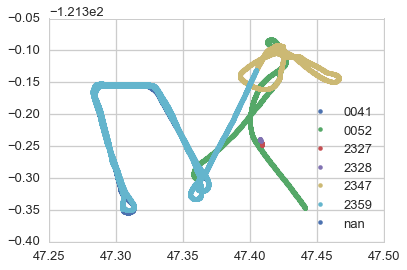

In [10]:
# --------------------------------------------------------------------------------------------
# Clean up the data to use
# Several of the files result in repeated time indices or don't exist or don't include location data
# This creates lots of problems when working in xarray. To alleviate this I'm going to remove the
# troublesome data from analysis on the basis of the below:

# Plot flight lines and flight numbers to diagnose what data to keep
for fln in np.unique(cameraLocDataset.flightNum.values):
    ds = cameraLocDataset.swap_dims({'time': 'flightNum'}).sel(flightNum=fln)
    plt.plot(ds.lat, ds.lon, '.', label=fln)
    plt.legend(loc='best')
    plt.savefig('SNQ.IRFlightNums.png')

# Print which files don't include IMU data
for filenum, irf in enumerate(irFiles):
    # --------------------------------------------------------------------------------------------
    # Read GPS/IMU
    cameraLoc = readIMU(irf['LOCATION'])
    # Name each flight according to the hour time stamp in each file name
    hourName = irf['LOCATION'].split('_')[2][0:4]
    print('File number ' + str(filenum + 1) + ' '+ ': ' + hourName)

Now let's see what's inside my location dataset:

In [12]:
# Based on the above let's drop files 1-6 and 9
# Additionally, the '2327' and '2328' flights don't appear to contain actual data. Drop those as well.
irFiles  = [fl10, fl11, fl12, fl13]

In [13]:
# --------------------------------------------------------------------------------------------
os.chdir(dirData)
timeChunkSize = 500
imageSubSample = 10  # Decimate the IR images for memory management

# --------------------------------------------------------------------------------------------
# Variables to pass to the read function:
paramsIR = np.array([1904, 1904, 16, 640, 480])
paramsVis = np.array([0, 0, 8, 1280, 960])

flightIterator = 0

for n, irf in enumerate(irFiles):
    flightIterator = flightIterator + 1
    # Empty xarray Dataset to fill
    cameraDataset = xr.Dataset()
    
    # --------------------------------------------------------------------------------------------
    # IR data name
    print("\r File " + str(n + 1) + " of " + str(np.size(irFiles)))
    fnameData = irf['IR1']
    
    # Name each flight according to the hour time stamp in each file name
    hourName = fnameData.split('_')[2][0:4]
    
    # --------------------------------------------------------------------------------------------
    # Determine the number of images per flight line
    infoOnlyFlag = True
    fIndex = 0
    info, cameraTime = readInfraredCamera(fnameData,
                                          findex=fIndex,
                                          params=paramsIR,
                                          infoOnlyFlag=infoOnlyFlag)

    # --------------------------------------------------------------------------------------------
    # Set-up chunking of binary reading 
    chunkNum = np.append(np.arange(0, int(info['nframes']), timeChunkSize ), int(info['nframes']))
    
    for nC, C in enumerate(chunkNum[0:-1]):
        # Empty xarray Dataset to fill
        cameraDataset = xr.Dataset()
        
        # Update chunking
        print("\r Chunk " + str(nC + 1) + " of " + str(np.size(chunkNum) - 1))
        fIndex = np.arange(chunkNum[nC], chunkNum[nC + 1], imageSubSample)
        fIndex = np.atleast_1d(fIndex)
        
        # --------------------------------------------------------------------------------------------
        # Read the binary file
        infoOnlyFlag = False
        cameraData, _ = readInfraredCamera(fnameData, findex=fIndex, params=paramsIR, infoOnlyFlag=infoOnlyFlag)
        if not cameraData:
            continue
        else:
            # Name each flight according to the hour time stamp in each file name
            hourName = irf['LOCATION'].split('_')[2][0:4]
            cameraData['flightNum'] = (('time'), [hourName] * cameraData.time.size)

        # Initialize dataset
        if not cameraDataset:
            cameraDataset = cameraData
        # Append to existing dataset
        elif cameraDataset:
            cameraDataset = xr.concat([cameraDataset, cameraData], dim='time')

        # To manage memory make netcdf files with 500 images each
        cameraDataset.to_netcdf('SNQ.IRFlight_' + str(flightIterator) + '.chunk' + str(nC + 1) + '.nc')

 File 1 of 4
 Chunk 1 of 15
 Chunk 2 of 15
 Chunk 3 of 15
 Chunk 4 of 15
 Chunk 5 of 15
 Chunk 6 of 15
 Chunk 7 of 15
 Chunk 8 of 15
 Chunk 9 of 15
 Chunk 10 of 15
 Chunk 11 of 15
 Chunk 12 of 15
 Chunk 13 of 15
 Chunk 14 of 15
 Chunk 15 of 15
 File 2 of 4
 Chunk 1 of 51
 Chunk 2 of 51
 Chunk 3 of 51
 Chunk 4 of 51
 Chunk 5 of 51
 Chunk 6 of 51
 Chunk 7 of 51
 Chunk 8 of 51
 Chunk 9 of 51
 Chunk 10 of 51
 Chunk 11 of 51
 Chunk 12 of 51
 Chunk 13 of 51
 Chunk 14 of 51
 Chunk 15 of 51
 Chunk 16 of 51
 Chunk 17 of 51
 Chunk 18 of 51
 Chunk 19 of 51
 Chunk 20 of 51
 Chunk 21 of 51
 Chunk 22 of 51
 Chunk 23 of 51
 Chunk 24 of 51
 Chunk 25 of 51
 Chunk 26 of 51
 Chunk 27 of 51
 Chunk 28 of 51
 Chunk 29 of 51
 Chunk 30 of 51
 Chunk 31 of 51
 Chunk 32 of 51
 Chunk 33 of 51
 Chunk 34 of 51
 Chunk 35 of 51
 Chunk 36 of 51
 Chunk 37 of 51
 Chunk 38 of 51
 Chunk 39 of 51
 Chunk 40 of 51
 Chunk 41 of 51
 Chunk 42 of 51
 Chunk 43 of 51
 Chunk 44 of 51
 Chunk 45 of 51
 Chunk 46 of 51
 Chunk 47 of 51


## Crude undistortion routine (not corrected for actual terrain)

In [126]:
# --------------------------------------------------------------------------------------------
# Undistortion coefficients

# Cameras point straight down relative to IMU orientation. Do an approximate image rectification,
# assuming a flat terrain at a fixed elevation. This will be wrong almost everywhere, but the
# basic scripts and funcitons are represented below. -- Chris comment

# Directly assign distortion coefficients instead of going to matlab
D0 = np.array([[  8.29156932e-07], [1.31482324e-02], [-2.73245123e-04]])
D1 = np.array([[  2.62118311e-07], [1.32719803e-02], [-1.23437066e-04]])

# Inherent camera parameters
ip0 = [1, -1, 640, 480, 320, -240]
ip0.extend(D0.flatten())
ip1 = [1, -1, 640, 480, 320, -240]
ip1.extend(D1.flatten())

# Mesh of distortion vectors
[Ud, Vd] = np.meshgrid(np.arange(0, ip0[2]), np.arange(0, ip0[3]))
# correct for barrel orpincusion distortion
[uU1, uV1] = undistortUV(Ud, Vd, ip1) 
[uU0, uV0] = undistortUV(Ud, Vd, ip0)
offsetAngsC0 = np.array([0, 0, 0]) * np.pi / 180

# offset to make C1 match C0
offsetAngsC1 = np.array([-.1, .1, .5]) * np.pi / 180
# need to adjust these for the focus, approximate with last used values -- Chris comment
fovC0 = 39
fovC1 = 25.5

# --------------------------------------------------------------------------------------------
# Undistortion dataset

# Undistort all images
timeSize = cameraDataset.time.size
xSize = cameraDataset.x.size
ySize = cameraDataset.y.size

chunkUndistort = xr.Dataset({'easting': (['x', 'y', 'time'], np.zeros((xSize, ySize, timeSize))),
                             'northing': (['x', 'y', 'time'], np.zeros((xSize, ySize, timeSize)))},
                            coords={'time': cameraDataset.time})
# chunkUndistort = chunkUndistort.chunk({'time': timeChunkSize})


# --------------------------------------------------------------------------------------------
# Correct each image
for n, t in enumerate(cameraDataset.time):
    # Dataset for this timestep
    ds = cameraLocDataset.isel(time=n)
    m0 = infoPRY2M(np.array([-ds['pitch'].values,
                             ds['azmth'].values,
                             fovC0,
                             -ds['roll'].values]) * np.pi / 180,
                    np.array([ds['easting'].values,
                              ds['northing'].values,
                              ds['elev'].values]),
                   ip0, 0, 0, 0)
    # Projection coordinates -- careful changing things here. The indexing methods of xarray will
    # silently fail when trying to assign.
    chunkUndistort['easting'][dict(time=n)], chunkUndistort['northing'][dict(time=n)], _ \
        = findXYZ(m0, uU0, uV0, np.array(1000), np.array(2)) # fixing land elevation to 1000m

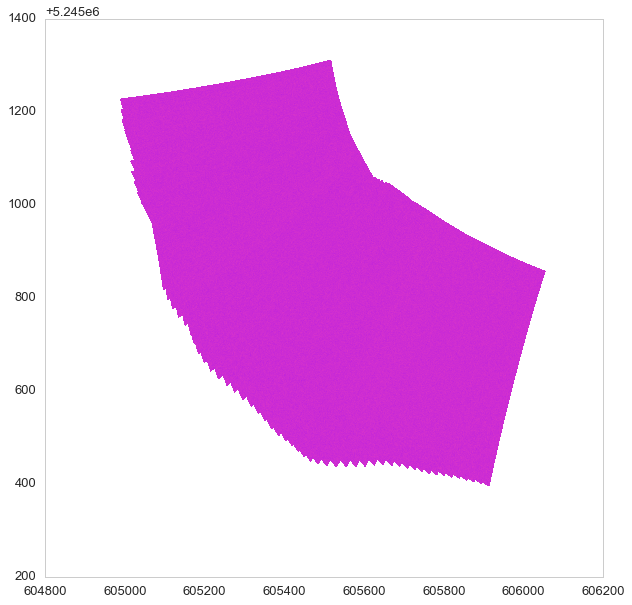

In [135]:
# Plot IR images
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for n in np.arange(0, cameraDataset.time.size):
    ax.pcolormesh(chunkUndistort.easting.isel(time=n),
                  chunkUndistort.northing.isel(time=n),
                  cameraDataset.isel(time=n).images.values,
                  cmap=cm.gnuplot2, vmin=0, vmax=20)